Enhancements:
- Include price that assets were bought into the state
- Explore neutral penalty
- Encoding layer to control/learn state representation
- Improve stability of learning algorithms through the use of PPO, SAC
- Create short-term endpoints for trading windows during training and shuffle these windows
- Feature selection and hyperparameter tuning through validation search [Discount rate, ]
- More sophistication for state-propagation, e.g. Recurrent NN, Transformer

TODO:
- Walk-forward validation training
- Test evaluation of all models
- Use trained value network and pretrained policy network?


Consider:
- Recreating the table on Slide 41 of 56 from this set of lecture slides would be good for our purposes https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf


Final report
- Describe RL
- Describe LOB
- What metric are we trying to optimise
- Inputs
- Literature review
- Results

## 1. Overview

Note that for this Reinforcement Learning problem, the actions available to the agent are:
- 0: Short   (Have -1 asset)
- 1: Neutral (Have 0 asset)
- 2: Long    (Have 1 asset)

## 2. Install the necessary packages
- Models
- Commons
- Environment manager

In [1]:
!pip install -e requirements_installer

Obtaining file:///home/e0310734/code/requirements_installer
  Attempting uninstall: rl-finance
    Found existing installation: rl-finance 0.1
    Uninstalling rl-finance-0.1:
      Successfully uninstalled rl-finance-0.1
  Running setup.py develop for rl-finance


## 3. Import packages

In [143]:
%load_ext autoreload
%autoreload 2

import random
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from rl_finance.environments import BaseEnvironment
from rl_finance.commons import Experience, ReplayMemory
from rl_finance.models import ActionValueNetwork, PolicyNetwork


%matplotlib inline
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
mlflow.set_tracking_uri("file:///home/e0310734/logs/mlruns")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 4. List the dataset locations

In [3]:
MONTH = 'jan'
datasets = []
dataset_scopes = ['minimal', 'minimal_window', 'full', 'full_window']
dataset_components = [
    'X_train.pt', 'X_validation.pt', 'X_test.pt',
    'y_train.pt', 'y_validation.pt', 'y_test.pt',
    'bid_train.pt', 'bid_val.pt', 'bid_test.pt',
    'ask_train.pt', 'ask_val.pt', 'ask_test.pt',
]

for dataset_scope in dataset_scopes:
    dataset = []
    for dataset_component in dataset_components:
        dataset.append("../data/processed_datasets/" + MONTH + "/" + dataset_scope + "/" + dataset_component)
    datasets.append(dataset)

## 5. State constant hyperparameters

In [34]:
ACTION_SPACE = [0, 1, 2]
OUTPUT_DIMS = 3
BATCH_SIZE = 512

N_EPOCHS = 150
EPOCH_TRAIN_START = 5  # Number of epochs to populate the ReplayMemory before we start sampling from it
LEARNING_RATE = 1e-6
REPLAY_MEMORY_SIZE = int(2**20)
DISCOUNT_RATE = 0.999
FROZEN_UPDATE_INTERVAL = 12

TRADING_FEE = 3e-5
NEUTRAL_PENALTY = 1e-5

## 6. Select exploration-exploitation trade-off parameters

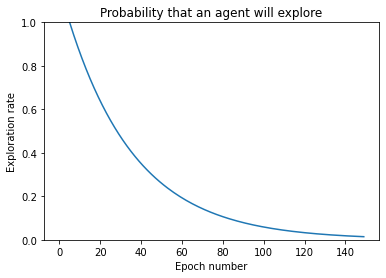

In [10]:
min_exploration_rate = 0.001
max_exploration_rate = 1.
exploration_decay_rate = 0.03
ers = []
for epoch in range(N_EPOCHS):
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(epoch - EPOCH_TRAIN_START))
    ers.append(exploration_rate)
pd.Series(ers).plot()
plt.title("Probability that an agent will explore")
plt.ylabel("Exploration rate")
plt.ylim((0,1))
plt.xlabel("Epoch number");

## 7. Reinforcement Learning: Deep Q Network

Start with a 1-pass algorithm then package it into a function and iterate over each of the hyperparameters

In [22]:
mlflow.set_experiment("DQN")

<Experiment: artifact_location='file:///home/e0310734/logs/mlruns/2', experiment_id='2', lifecycle_stage='active', name='DQN', tags={}>

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test, bid_train, bid_val, bid_test, ask_train, ask_val, ask_test = [torch.load(path) for path in datasets[0]]

In [18]:
INPUT_DIM = X_train.shape[-1]
OUTPUT_DIM = 3

In [157]:
env = BaseEnvironment(X_train, bid_train, ask_train, use_midprice=False)
replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE)

action_value_network = ActionValueNetwork(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
action_value_network.to(device)

target_action_value_network = ActionValueNetwork(input_dim=INPUT_DIM, output_dim=OUTPUT_DIM)
target_action_value_network.load_state_dict(action_value_network.state_dict())
target_action_value_network.to(device)

action_value_network_optimizer = optim.Adam(params=action_value_network.parameters(), lr=LEARNING_RATE)

In [175]:
EPOCH_TRAIN_START = 1
BATCH_SIZE = 5
N_EPOCHS = 3

In [176]:
action_value_loss_history = []
reward_history = []

best_episode_reward = float("-inf")
best_episode_validation_reward = float("-inf")

loss_fn = nn.MSELoss()

for epoch in range(N_EPOCHS):
    action_value_network.train()
    
    episode_action_history = []
    episode_reward = 0
    
    done = False
    state = env.reset()
    
    while not done:
        
        # Exploration vs Exploitation
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(epoch - EPOCH_TRAIN_START))
        if random.uniform(0, 1) > exploration_rate:
            action_value_network(state).argmax()
        else:
            action = torch.tensor(random.sample(ACTION_SPACE, 1)).to(device) # Explore
        
        next_state, reward, done = env.step(action.item())
        
        # Saves
        replay_memory.push(Experience(state, action, reward, next_state, done))
        episode_action_history.append(action.item())
        episode_reward += reward
        state = next_state
        
        if (epoch >= EPOCH_TRAIN_START) and (replay_memory.can_provide_sample(BATCH_SIZE)):
            states, actions, rewards, next_states, dones = replay_memory.sample(BATCH_SIZE)
            
            states = torch.stack(states, dim=0).to(device)
            actions = torch.cat(actions, dim=0).to(device)
            rewards = torch.tensor(rewards).float().to(device)
            next_states = torch.stack(next_states, dim=0).to(device)
            dones = torch.tensor(dones).float().to(device)
            
            # Error calculation
            # action_targets = value_network(next_states).max(dim=-1)[1].unsqueeze(-1)
            # target_values = rewards + (1 - dones) * DISCOUNT_RATE * fixed_network(next_states).gather(-1, action_targets).squeeze(-1) # Double DQN
            target_values = rewards + (1 - dones) * DISCOUNT_RATE * target_action_value_network(next_states).max(dim=-1)[0] # DQN
            target_values = target_values.detach()

            current_values = action_value_network(states).gather(-1, actions.unsqueeze(-1)).squeeze(1)

            # Loss
            loss = loss_fn(current_values, target_values)
            action_value_network_optimizer.zero_grad()
            loss.backward()
            action_value_network_optimizer.step()
        

KeyboardInterrupt: 

In [181]:
x =None

In [182]:
x is None

True

In [192]:
actions.dtype

torch.int64

In [183]:
x == None

True

In [180]:
Experience?

Init signature: Experience(state, action, reward, next_state, done)
Docstring:      Experience(state, action, reward, next_state, done)
File:           ~/code/requirements_installer/rl_finance/commons/experience.py
Type:           type
Subclasses:     


In [76]:
for epoch in range(N_EPOCHS):
    value_network.train()
    episode_action_history = []
    done = False
    episode_reward = 0
    state = X_train[0].clone()
    bid, ask = bid_train[0], ask_train[0]

    for i in range(1, X_train.shape[0]):
        # Explore vs exploit
        exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(epoch - EPOCH_TRAIN_START))
        if random.uniform(0, 1) > exploration_rate:
            value_network(state).argmax()
        else:
            action = torch.tensor(random.sample(ACTION_SPACE, 1)).to(device) # Explore

        # Environment step
        next_state = X_train[i].clone()
        next_state[..., -1] = action
        next_bid = bid_train[i]
        next_ask = ask_train[i]

        reward = get_reward(state, bid, ask, next_state, next_bid, next_ask, use_midprice=USE_MIDPRICE, trading_fee=TRADING_FEE, neutral_penalty=NEUTRAL_PENALTY)
        done = i == (X_train.shape[0] - 1)

        # Saves
        replay_memory.push(Experience(state, action, reward, next_state, done))
        episode_action_history.append(action.item())
        episode_reward += reward
        state = next_state
        bid = next_bid
        ask = next_ask

        if replay_memory.can_provide_sample(BATCH_SIZE) and epoch > EPOCH_TRAIN_START:
            states, actions, rewards, next_states, dones = replay_memory.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)
            actions = actions.long()
            dones = dones.float()

            # Error calculation
            action_targets = value_network(next_states).max(dim=-1)[1].unsqueeze(-1)
            target_values = rewards + (1 - dones) * DISCOUNT_RATE * fixed_network(next_states).gather(-1, action_targets).squeeze(-1) # Double DQN
            # target_values = rewards + (1 - dones) * DISCOUNT_RATE * q_fn_frozen(next_states).max(dim=-1)[0] # DQN

            current_values = value_network(states).gather(-1, actions.unsqueeze(-1)).squeeze(1)

            # Loss
            loss = mse_fn(current_values, target_values.detach())
            value_optimizer.zero_grad()
            loss.backward()
            value_optimizer.step()

    reward_history.append(episode_reward) ######## LOG THE REWARD
    mlflow.log_metric("episode_reward", episode_reward, step=epoch)

    if replay_memory.can_provide_sample(BATCH_SIZE) and i % FROZEN_UPDATE_INTERVAL == 0 and epoch > EPOCH_TRAIN_START:
        fixed_network.load_state_dict(value_network.state_dict())
        fixed_network.eval()

    if replay_memory.can_provide_sample(BATCH_SIZE) and epoch > EPOCH_TRAIN_START:
            print(f"Epoch: {epoch:>5,d}, Reward: {episode_reward:>10,.6f}, Value loss: {loss.item():>10,.6f}", end="\r")
            mlflow.log_metric("train_value_network_loss", loss.item(), step=epoch)

            # Save episode action information - Need to see if the agent is changing its portfolio regularly
            for k, v in dict(pd.Series(episode_action_history).value_counts()).items():
                mlflow.log_metric(f"action_{k}", v, step=epoch)

    if (episode_reward > best_episode_reward):
        best_episode_reward = episode_reward
        torch.save(value_network.state_dict(), "best_train_value_state_dict.pt")
        mlflow.log_artifact("best_train_value_state_dict.pt")
################
    with torch.no_grad():
        # Validation checks
        value_network.eval()
        val_state = X_val[0]
        val_bid = bid_val[0]
        val_ask = ask_val[0]
        validation_reward = 0
        validation_actions = []

        for k in range(1, X_val.shape[0]):
            val_action = value_network(val_state).argmax()

            val_next_state = X_val[k]
            val_next_state[..., -1] = val_action

            val_next_bid = bid_val[k]
            val_next_ask = ask_val[k]

            reward = get_reward(val_state, val_bid, val_ask, val_next_state, val_next_bid, val_next_ask, neutral_penalty=0)
            validation_reward += reward
            validation_actions.append(val_action.item())
            val_state = val_next_state
            val_bid = val_next_bid
            val_ask = val_next_ask

        mlflow.log_metric("validation_episode_reward", validation_reward, step=epoch)
        for key, value in dict(pd.Series(validation_actions).value_counts()).items():
            mlflow.log_metric(f"validation_action_{key}", value, step=epoch)

        if validation_reward > best_episode_validation_reward:
            best_episode_validation_reward = validation_reward
            torch.save(value_network.state_dict(), "best_val_value_state_dict.pt")
            mlflow.log_artifact("best_val_value_state_dict.pt")
        value_network.train()

torch.save(value_network.state_dict(), "last_train_value_state_dict.pt")
mlflow.log_artifact("last_train_value_state_dict.pt")

NameError: name 'value_network' is not defined

In [ ]:
for dataset in datasets:
    for USE_MIDPRICE in [False, True]:
        # Fetch data
        X_train, X_val, X_test, y_train, y_val, y_test, bid_train, bid_val, bid_test, ask_train, ask_val, ask_test = [torch.load(path) for path in dataset]
        y_train, y_val, y_test = y_train.long(), y_val.long(), y_test.long()
        INPUT_DIMS = X_train.shape[-1]
        
        value_network = ValueNetwork(input_dim = INPUT_DIMS, output_dim = OUTPUT_DIMS).to(device)
        fixed_network = ValueNetwork(input_dim = INPUT_DIMS, output_dim = OUTPUT_DIMS).to(device)
        fixed_network.load_state_dict(value_network.state_dict())
        value_network.train()
        fixed_network.eval()
        
        value_optimizer = optim.Adam(params=value_network.parameters(), lr=LEARNING_RATE)
        mse_fn = nn.MSELoss()
        
        # Begin logging
        with mlflow.start_run() as run:
            mlflow.log_params({
                'batch_size': BATCH_SIZE,
                'n_epochs': N_EPOCHS,
                'train_start_epoch': EPOCH_TRAIN_START,
                'learning_rate': LEARNING_RATE,
                'replay_memory_size': REPLAY_MEMORY_SIZE,
                'discount_rate': DISCOUNT_RATE,
                'frozen_update_interval': FROZEN_UPDATE_INTERVAL,
                'use_midprice': USE_MIDPRICE,
                'trading_fee': TRADING_FEE,
                'neutral_penalty': NEUTRAL_PENALTY,
                'market_open': MARKET_OPEN,
                'market_close': MARKET_CLOSE,
                'granularity': GRANULARITY,
                'month': MONTH,
                'datascope': dataset[0].split("/")[2],
                'device': device,
                'input_dims': INPUT_DIMS,
                'critic_loss_fn': 'MSE',
                'network_optimizer_fns': 'Adam',
                'pretrain_loss_fn': 'CrossEntropyLoss',
                'policy_network': str(value_network.linear_stack).replace("in_features=", "").replace("out_features=", "").replace(" ", "").replace("\n", "").replace(",bias=True", ""),
                'min_exploration_rate': min_exploration_rate,
                'max_exploration_rate': max_exploration_rate,
                'exploration_decay_rate': exploration_decay_rate,
            })

            critic_loss_history = []
            policy_loss_history = []
            reward_history = []
            replay_memory = ReplayMemory(REPLAY_MEMORY_SIZE) # 2**20 values
            
            best_episode_reward = float("-inf")
            best_episode_validation_reward = float("-inf")

            for epoch in range(N_EPOCHS):
                value_network.train()
                episode_action_history = []
                done = False
                episode_reward = 0
                state = X_train[0].clone()
                bid, ask = bid_train[0], ask_train[0]

                for i in range(1, X_train.shape[0]):
                    # Explore vs exploit
                    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(epoch - EPOCH_TRAIN_START))
                    if random.uniform(0, 1) > exploration_rate:
                        value_network(state).argmax()
                    else:
                        action = torch.tensor(random.sample(ACTION_SPACE, 1)).to(device) # Explore

                    # Environment step
                    next_state = X_train[i].clone()
                    next_state[..., -1] = action
                    next_bid = bid_train[i]
                    next_ask = ask_train[i]

                    reward = get_reward(state, bid, ask, next_state, next_bid, next_ask, use_midprice=USE_MIDPRICE, trading_fee=TRADING_FEE, neutral_penalty=NEUTRAL_PENALTY)
                    done = i == (X_train.shape[0] - 1)

                    # Saves
                    replay_memory.push(Experience(state, action, reward, next_state, done))
                    episode_action_history.append(action.item())
                    episode_reward += reward
                    state = next_state
                    bid = next_bid
                    ask = next_ask

                    if replay_memory.can_provide_sample(BATCH_SIZE) and epoch > EPOCH_TRAIN_START:
                        states, actions, rewards, next_states, dones = replay_memory.sample(BATCH_SIZE)
                        states, actions, rewards, next_states, dones = states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)
                        actions = actions.long()
                        dones = dones.float()

                        # Error calculation
                        action_targets = value_network(next_states).max(dim=-1)[1].unsqueeze(-1)
                        target_values = rewards + (1 - dones) * DISCOUNT_RATE * fixed_network(next_states).gather(-1, action_targets).squeeze(-1) # Double DQN
                        # target_values = rewards + (1 - dones) * DISCOUNT_RATE * q_fn_frozen(next_states).max(dim=-1)[0] # DQN

                        current_values = value_network(states).gather(-1, actions.unsqueeze(-1)).squeeze(1)

                        # Loss
                        loss = mse_fn(current_values, target_values.detach())
                        value_optimizer.zero_grad()
                        loss.backward()
                        value_optimizer.step()

                reward_history.append(episode_reward) ######## LOG THE REWARD
                mlflow.log_metric("episode_reward", episode_reward, step=epoch)

                if replay_memory.can_provide_sample(BATCH_SIZE) and i % FROZEN_UPDATE_INTERVAL == 0 and epoch > EPOCH_TRAIN_START:
                    fixed_network.load_state_dict(value_network.state_dict())
                    fixed_network.eval()

                if replay_memory.can_provide_sample(BATCH_SIZE) and epoch > EPOCH_TRAIN_START:
                        print(f"Epoch: {epoch:>5,d}, Reward: {episode_reward:>10,.6f}, Value loss: {loss.item():>10,.6f}", end="\r")
                        mlflow.log_metric("train_value_network_loss", loss.item(), step=epoch)
                        
                        # Save episode action information - Need to see if the agent is changing its portfolio regularly
                        for k, v in dict(pd.Series(episode_action_history).value_counts()).items():
                            mlflow.log_metric(f"action_{k}", v, step=epoch)
                            
                if (episode_reward > best_episode_reward):
                    best_episode_reward = episode_reward
                    torch.save(value_network.state_dict(), "best_train_value_state_dict.pt")
                    mlflow.log_artifact("best_train_value_state_dict.pt")
################
                with torch.no_grad():
                    # Validation checks
                    value_network.eval()
                    val_state = X_val[0]
                    val_bid = bid_val[0]
                    val_ask = ask_val[0]
                    validation_reward = 0
                    validation_actions = []

                    for k in range(1, X_val.shape[0]):
                        val_action = value_network(val_state).argmax()

                        val_next_state = X_val[k]
                        val_next_state[..., -1] = val_action

                        val_next_bid = bid_val[k]
                        val_next_ask = ask_val[k]

                        reward = get_reward(val_state, val_bid, val_ask, val_next_state, val_next_bid, val_next_ask, neutral_penalty=0)
                        validation_reward += reward
                        validation_actions.append(val_action.item())
                        val_state = val_next_state
                        val_bid = val_next_bid
                        val_ask = val_next_ask

                    mlflow.log_metric("validation_episode_reward", validation_reward, step=epoch)
                    for key, value in dict(pd.Series(validation_actions).value_counts()).items():
                        mlflow.log_metric(f"validation_action_{key}", value, step=epoch)

                    if validation_reward > best_episode_validation_reward:
                        best_episode_validation_reward = validation_reward
                        torch.save(value_network.state_dict(), "best_val_value_state_dict.pt")
                        mlflow.log_artifact("best_val_value_state_dict.pt")
                    value_network.train()

            torch.save(value_network.state_dict(), "last_train_value_state_dict.pt")
            mlflow.log_artifact("last_train_value_state_dict.pt")
            

## DQN